### Here let's solve Lorenz 63 and see at what point we start getting chaotic behavior

In [1]:
# imports and config
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt

# Enable 64-bit floats in JAX (do this before creating JAX arrays / tracing)
jax.config.update("jax_enable_x64", True)

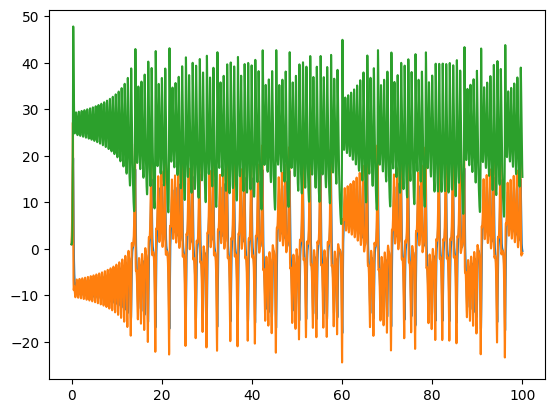

In [2]:
def lorenz_rhs(t, y, args):
    sigma, rho, beta = args
    x,y_,z = y
    return jnp.array([sigma*(y_-x), x*(rho-z)-y_, x*y_-beta*z])

solver = diffrax.Tsit5()
term = diffrax.ODETerm(lorenz_rhs)
saveat = diffrax.SaveAt(ts=jnp.linspace(0,100,20001))
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
sol = diffrax.diffeqsolve(term, 
                        solver, 
                        t0=0.0, 
                        t1=100.0, 
                        dt0=0.01,
                        y0=jnp.array([1.,1.,1.]), 
                        args=(10.,28.,8/3), 
                        saveat=saveat,
                        max_steps=200000,
                        stepsize_controller=stepsize_controller
                        )

plt.plot(sol.ts, sol.ys)

In [3]:
def lorenz_rhs(t, y, args):
    sigma, rho, beta = args
    x, y_, z = y
    return jnp.array([sigma * (y_ - x),
                      x * (rho - z) - y_,
                      x * y_ - beta * z], dtype=jnp.float64)

# Use float64 everywhere
solver = diffrax.Tsit5()
term = diffrax.ODETerm(lorenz_rhs)
saveat = diffrax.SaveAt(ts=jnp.linspace(0.0, 100.0, 20001, dtype=jnp.float64))
stepsize_controller = diffrax.PIDController(rtol=1e-12, atol=1e-12)
higher_def_sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=jnp.float64(0.0),
    t1=jnp.float64(100.0),
    dt0=jnp.float64(0.01),
    y0=jnp.array([1.0, 1.0, 1.0], dtype=jnp.float64),
    args=(jnp.float64(10.0), jnp.float64(28.0), jnp.float64(8.0 / 3.0)),
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=200000,
)

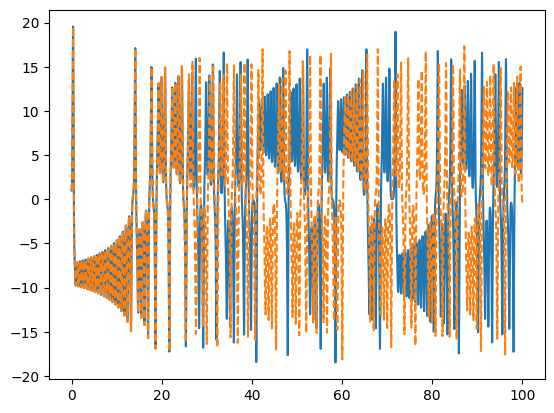

In [4]:
plt.plot(higher_def_sol.ts, higher_def_sol.ys[:, 0])
plt.plot(sol.ts, sol.ys[:, 0], linestyle='dashed')

In [5]:
### Show the l2 error between the two solutions
# We can see here that the solutions diverge after some time, as expected for a chaotic system
# And we see that the error becomes O(1) after some time as the systems diverge with comparable scale to the states
# This is consistent with the Shadow lemma because even the 32 bit solution is a "true" solution to a slightly perturbed initial condition

l2_error = jnp.linalg.norm(higher_def_sol.ys - sol.ys, axis=1)

l2_error.shape

(20001,)

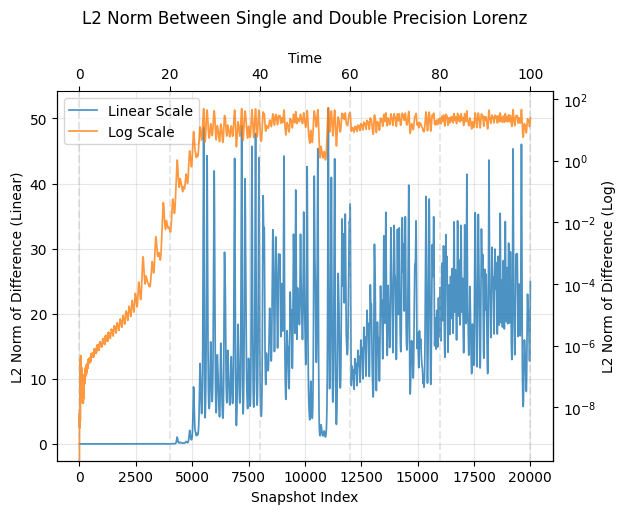

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
time_indices = jnp.arange(len(l2_error))

# Use the actual time values from the solution instead of fixed dt
actual_time = higher_def_sol.ts  # or sol.ts, they should be the same

# Plot on primary (left) axis - linear scale
line1 = ax.plot(time_indices, l2_error, lw=1.25, color='tab:blue', label='Linear Scale', alpha=0.8)
ax.set_ylabel('L2 Norm of Difference (Linear)')
ax.set_xlabel('Snapshot Index')
ax.set_title('L2 Norm Between Single and Double Precision Lorenz', pad=20)
ax.grid(alpha=0.3)
ax.tick_params(axis='y')

# Create secondary (right) y-axis - log scale
ax2 = ax.twinx()
line2 = ax2.plot(time_indices, l2_error, lw=1.25, color='tab:orange', alpha=0.8, label='Log Scale')
ax2.set_yscale('log')
ax2.set_ylabel('L2 Norm of Difference (Log)')
ax2.tick_params(axis='y')

# Create secondary (top) x-axis for actual time
ax3 = ax.twiny()
# Plot invisible line to establish the axis relationship
ax3.plot(actual_time, l2_error, alpha=0)  # Invisible plot to set limits
ax3.set_xlabel('Time')
ax3.xaxis.set_label_position('top')
ax3.xaxis.tick_top()
ax3.grid(alpha=0.3, linestyle='--', lw=1.5)

# Remove top spine for the primary axes
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
# Keep the top spine for ax3 as it shows the secondary x-axis
ax3.spines['bottom'].set_visible(False)

# Optional: Remove left spine as in original
ax.spines['left'].set_visible(False)

# Combine legends from both y-axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

# Save figure
fig.savefig('single_vs_double_lorenz.png', dpi=300, bbox_inches='tight')

### DMD Experiments

/home/anthonypoole/repos/PyDMD/pydmd/snapshots.py:73: UserWarning: Input data condition number 38103273664.93951. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


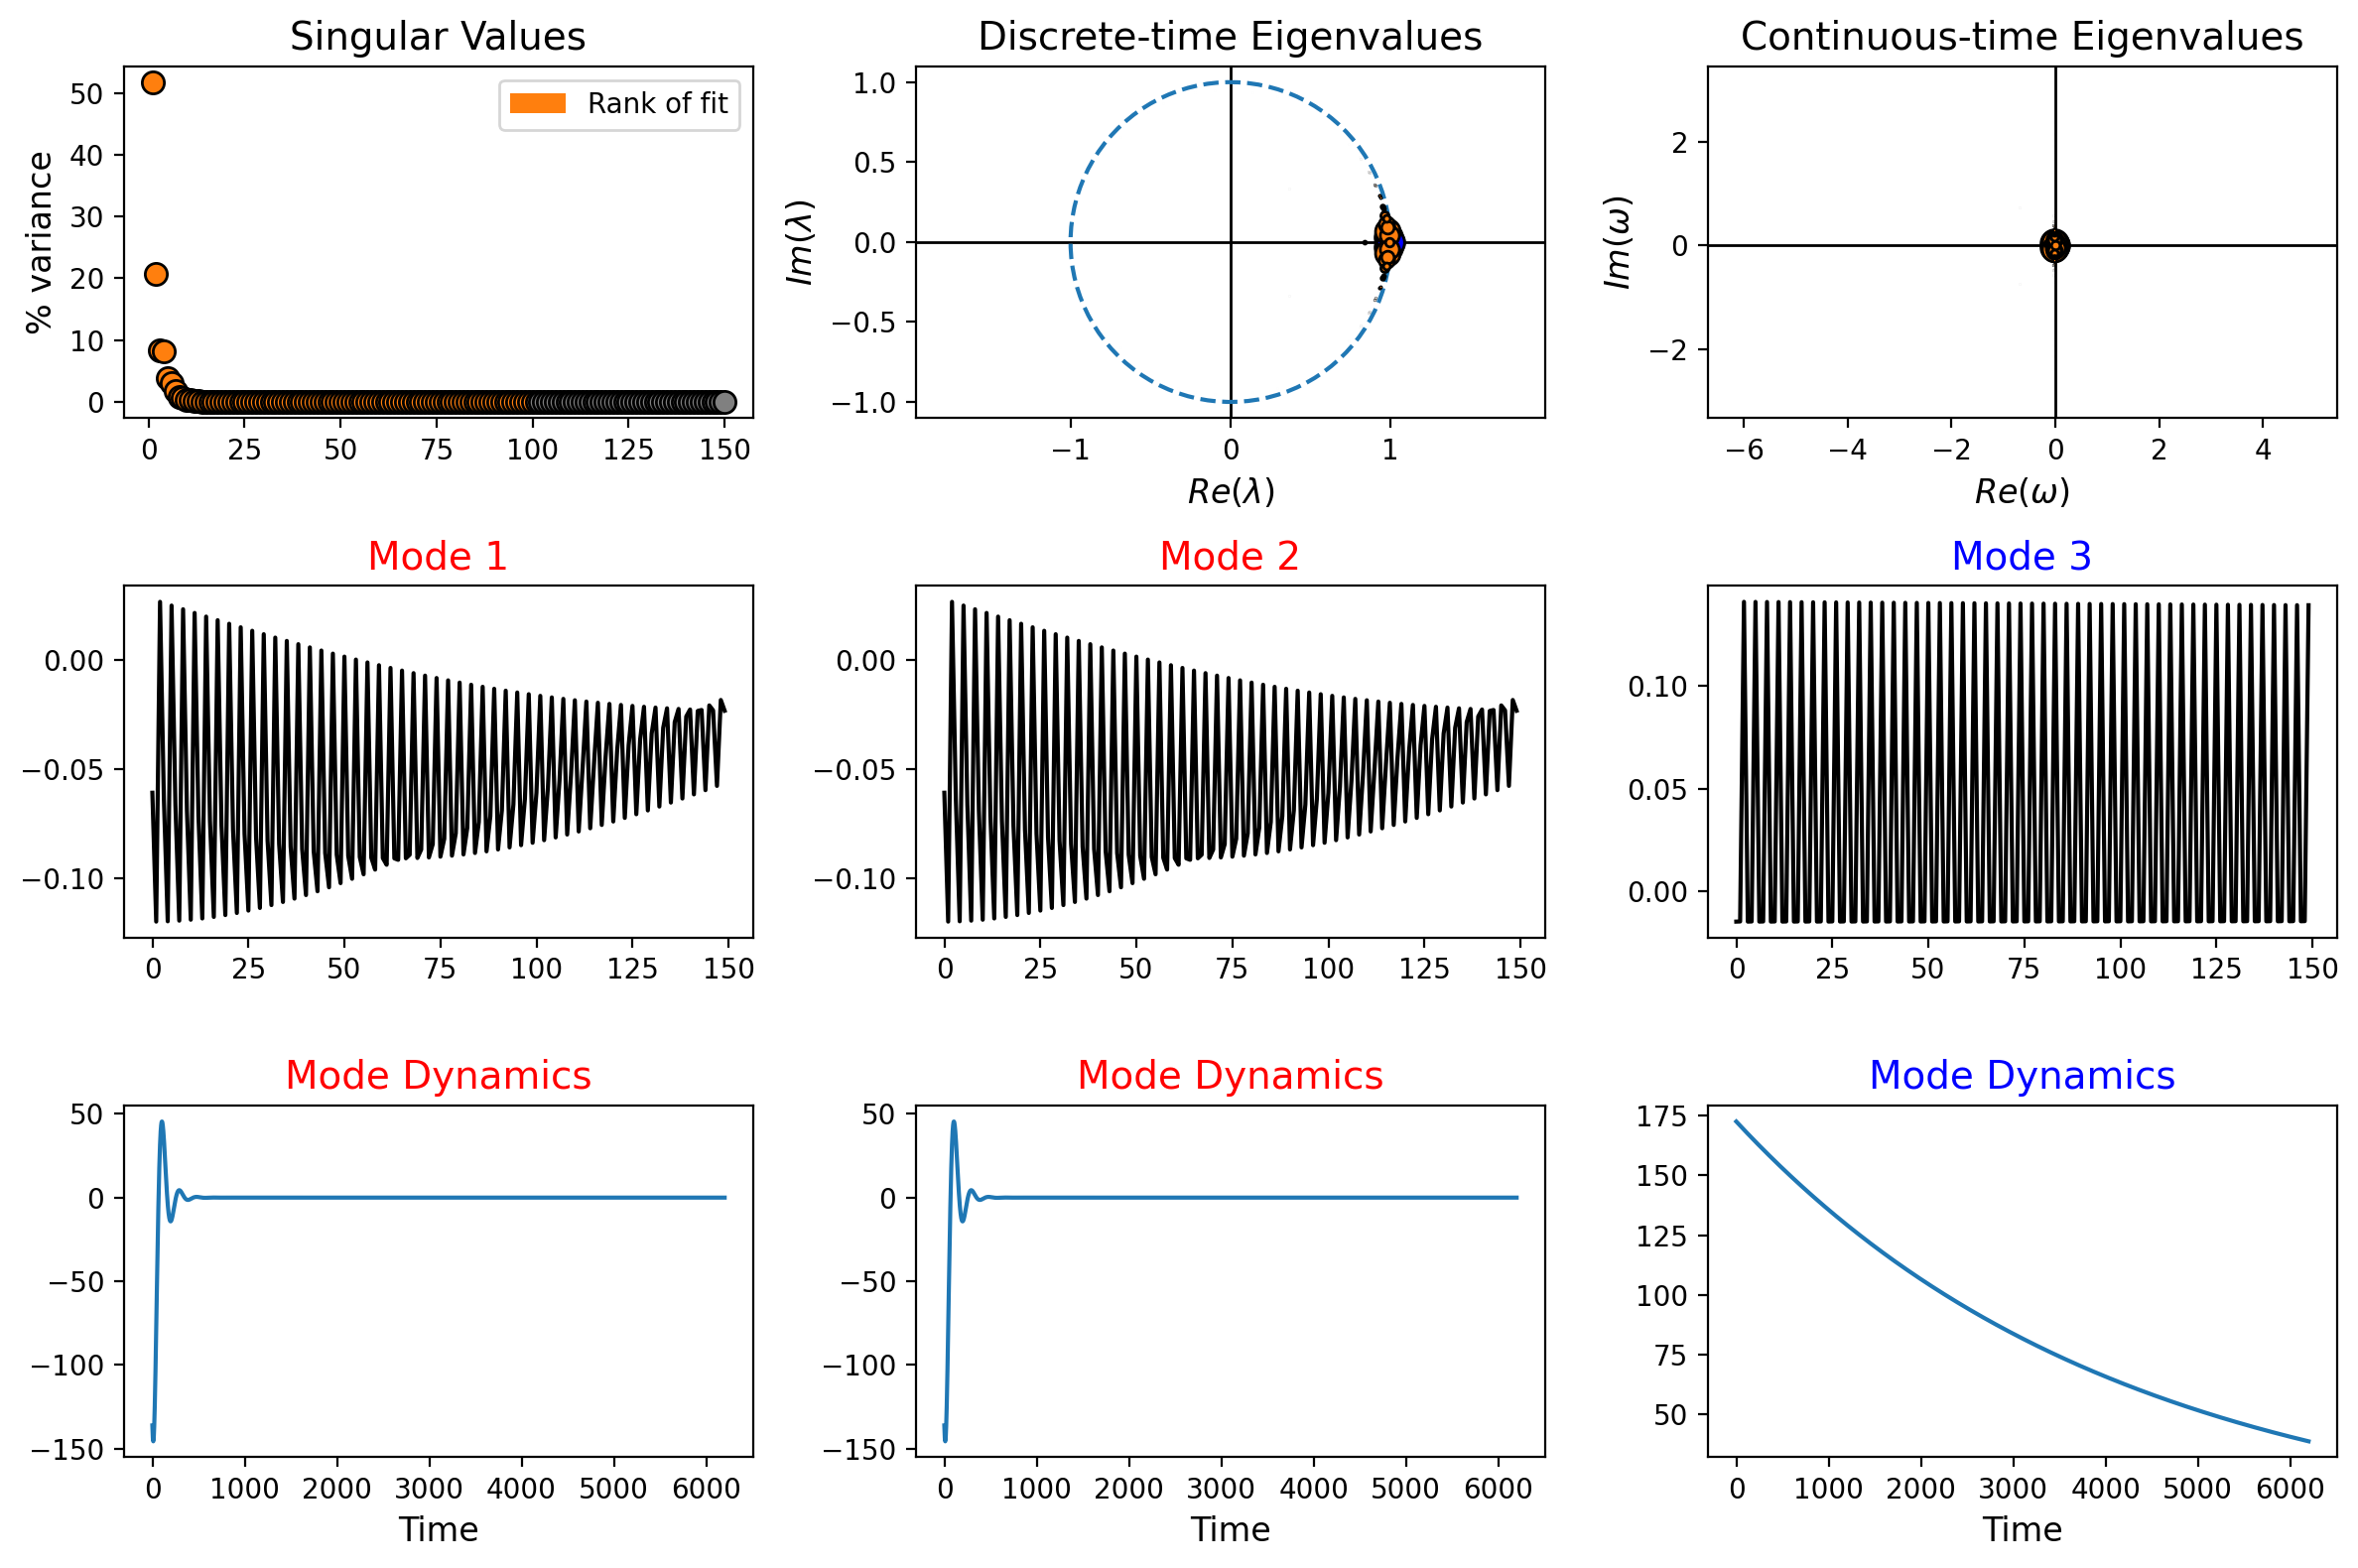

Frequencies (imaginary component): [-6.19517458e-02+3.14159265j -7.33764101e-02+3.14159265j
 -6.27147851e-02+2.99133632j -6.27147851e-02-2.99133632j
 -6.68468619e-02+3.01469633j -6.68468619e-02-3.01469633j
 -5.76335091e-02+2.85204572j -5.76335091e-02-2.85204572j
 -7.55495199e-02+2.89210799j -7.55495199e-02-2.89210799j
 -6.93176479e-02+2.76969443j -6.93176479e-02-2.76969443j
 -6.19972037e-02+2.72197114j -6.19972037e-02-2.72197114j
 -7.05794038e-02+2.65712934j -7.05794038e-02-2.65712934j
 -5.54223521e-02+2.59043023j -5.54223521e-02-2.59043023j
 -5.22096134e-02+2.51387195j -5.22096134e-02-2.51387195j
 -6.03983032e-02+2.46688848j -6.03983032e-02-2.46688848j
 -4.93753236e-02+2.37948408j -4.93753236e-02-2.37948408j
 -6.25733204e-02+2.33508756j -6.25733204e-02-2.33508756j
 -4.65505345e-02+2.26109788j -4.65505345e-02-2.26109788j
 -5.99275425e-02+2.19883981j -5.99275425e-02-2.19883981j
 -9.81391191e-03+2.1430542j  -9.81391191e-03-2.1430542j
 -3.96519012e-02+2.13620629j -3.96519012e-02-2.1362062

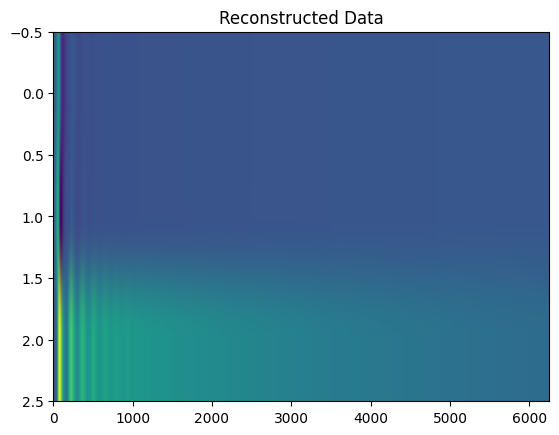

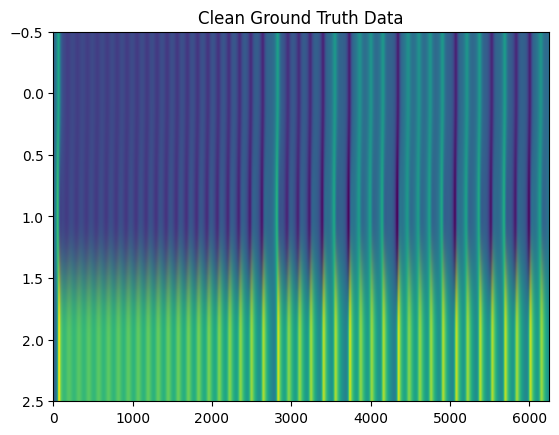

In [7]:
from pydmd import DMD
from pydmd.plotter import plot_summary
from pydmd.preprocessing import hankel_preprocessing

training_snapshots = sol.ys.T[:, :6250]
training_time_domain = sol.ts[:6250]

# 50, 100
d = 50  # we will use this number of delays throughout the tutorial
dmd_basic = DMD(svd_rank=100)
dmd = hankel_preprocessing(dmd_basic, d=d)
dmd.fit(training_snapshots)

plot_summary(dmd, max_sval_plot=1000)

print(
    f"Frequencies (imaginary component): {np.round(np.log(dmd.eigs) / 1, decimals=12)}"
)
plt.title("Reconstructed Data")
plt.imshow(dmd.reconstructed_data.real, aspect='auto')
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(training_snapshots, aspect='auto')
plt.show()

In [13]:
len(sol.ts)

20001

{'t0': 0, 'tend': 20000, 'dt': 1}
{'t0': 0, 'tend': 20000, 'dt': 1}


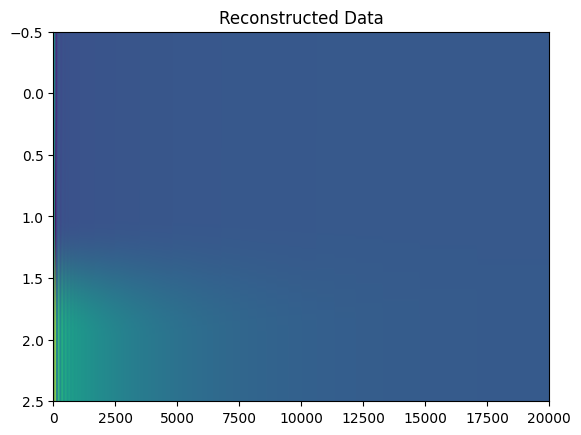

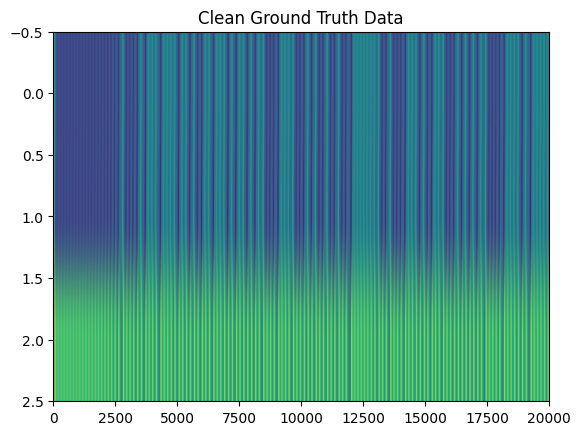

20050

In [18]:
print(dmd.dmd_time)
dmd.dmd_time['tend'] = len(sol.ts) - 1
print(dmd.dmd_time)

reconstructed_trimmed = dmd.reconstructed_data[:, :sol.ts.shape[0]]


plt.title("Reconstructed Data")
plt.imshow(reconstructed_trimmed.real, aspect='auto')
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(sol.ys.T, aspect='auto')
plt.show()

len(dmd.reconstructed_data.real.T)

### Let's compute the power spectra



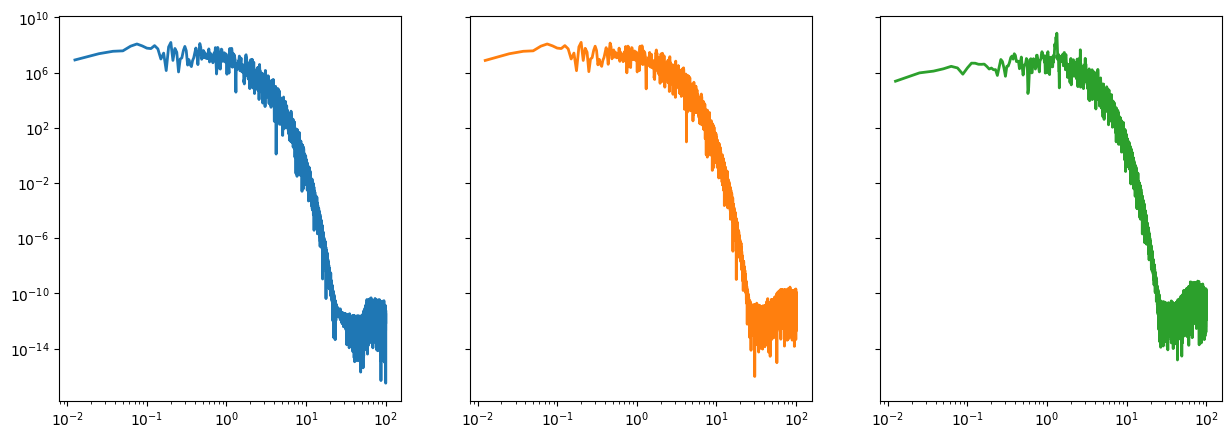

In [22]:
# Remove transients (first 20 time units)
idx_start = jnp.where(sol.ts > 20)[0][0]
gt_data = sol.ys[idx_start:, :]  # each column is a variable
pred_data = reconstructed_trimmed[idx_start:, :]
# print(gt_data.shape, pred_data.shape)
# data = np.stack((gt_data, pred_data), axis=0).reshape(-1, 3)

# Detrend each variable
from scipy import signal
data_detrended = signal.detrend(gt_data, axis=0)

# Apply window (e.g., Hann)
window = signal.windows.hann(len(data_detrended))
data_windowed = data_detrended * window[:, None]

# Compute FFT
fft = jnp.fft.rfft(data_windowed, axis=0)
power = jnp.abs(fft)**2
freqs = jnp.fft.rfftfreq(len(data_windowed), d=sol.ts[1]-sol.ts[0])

fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)

# Plot
ax[0].loglog(freqs[1:], power[1:, 0], lw = 2, color='tab:blue')  # skip DC component
ax[1].loglog(freqs[1:], power[1:, 1], lw = 2, color='tab:orange')  # skip DC component
ax[2].loglog(freqs[1:], power[1:, 2], lw = 2, color='tab:green')  # skip DC component

# ax[1,0].loglog(freqs[1:], power[1:, 3], lw = 2, color='tab:blue')  # skip DC component
# ax[1,1].loglog(freqs[1:], power[1:, 4], lw = 2, color='tab:orange')  # skip DC component
# ax[1,2].loglog(freqs[1:], power[1:, 5], lw = 2, color='tab:green')  # skip DC component